# Card Classification via Perceptual Hashing

In this notebook, we explore using perceptual hashing to classify Pokémon cards.

## Download cards from json

We use the metadata jsons to download all the card images.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install -Uqq imagehash fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 10.0 MB/s eta 0:00:00


In [3]:
# Currently loaded sets ~19600 cards in total
!ls gdrive/MyDrive/4ZP6/data/jsons

cards_2011bw.json    cards_exu.json	 cards_sv07.json
cards_2012bw.json    cards_fut2020.json  cards_sv08.5.json
cards_2014xy.json    cards_g1.json	 cards_sv08.json
cards_2015xy.json    cards_gym1.json	 cards_sv09.json
cards_2016xy.json    cards_gym2.json	 cards_sv10.5b.json
cards_2017sm.json    cards_hgss1.json	 cards_sv10.5w.json
cards_2018sm.json    cards_hgss2.json	 cards_sv10.json
cards_2019sm.json    cards_hgss3.json	 cards_svp.json
cards_2021swsh.json  cards_hgss4.json	 cards_swsh10.5.json
cards_base1.json     cards_hgssp.json	 cards_swsh10.json
cards_base2.json     cards_jumbo.json	 cards_swsh11.json
cards_base3.json     cards_lc.json	 cards_swsh12.5.json
cards_base4.json     cards_me01.json	 cards_swsh12.json
cards_base5.json     cards_neo1.json	 cards_swsh1.json
cards_basep.json     cards_neo2.json	 cards_swsh2.json
cards_bog.json	     cards_neo3.json	 cards_swsh3.5.json
cards_bw10.json      cards_neo4.json	 cards_swsh3.json
cards_bw11.json      cards_np.json	 cards_swsh4.5.js

In [4]:
from fastai.vision.all import *
from fastdownload import download_url
import os

In [5]:
path = Path('gdrive/MyDrive/4ZP6/data/jsons')

In [6]:
pokemon_sets = os.listdir(path)
pokemon_sets[0:5], len(pokemon_sets)

(['cards_jumbo.json',
  'cards_wp.json',
  'cards_basep.json',
  'cards_base2.json',
  'cards_base3.json'],
 183)

In [7]:
import json

In [8]:
all_cards = []
for pokemon_set in pokemon_sets:
    with open(f'{path}/{pokemon_set}', 'r') as file:
        json_data = json.load(file)
        cards = json_data['cards']
        for card in cards:
            all_cards.append(card)

len(all_cards), all_cards[0]

(19970,
 {'category': 'Pokemon',
  'id': 'basep-1',
  'illustrator': 'Keiji Kinebuchi',
  'image': 'https://assets.tcgdex.net/en/base/basep/1',
  'localId': '1',
  'name': 'Pikachu',
  'rarity': 'Common',
  'set': {'cardCount': {'official': 53, 'total': 53},
   'id': 'basep',
   'logo': 'https://assets.tcgdex.net/en/base/basep/logo',
   'name': 'Wizards Black Star Promos',
   'symbol': 'https://assets.tcgdex.net/univ/base/basep/symbol'},
  'variants': {'firstEdition': False,
   'holo': True,
   'normal': True,
   'reverse': True,
   'wPromo': False},
  'variants_detailed': [{'type': 'normal', 'size': 'standard'},
   {'type': 'reverse', 'size': 'standard'},
   {'type': 'holo', 'size': 'standard'}],
  'dexId': [25],
  'hp': 60,
  'types': ['Lightning'],
  'stage': 'Basic',
  'attacks': [{'cost': ['Colorless'],
    'name': 'Growl',
    'effect': "If the Defending Pokémon attacks Pikachu during your opponent's next turn, any damage done by the attack is reduced by 10 (after applying Weakne

In [41]:
id_to_url = {}
id_to_card = {}
for card in all_cards:
    id_to_card[card['id']] = card
    if 'image' in card:
        id_to_url[card['id']] = f'{card['image']}/high.jpg'

len(id_to_url), list(id_to_url.items())[0]

(19029, ('basep-1', 'https://assets.tcgdex.net/en/base/basep/1/high.jpg'))

In [16]:
def download_imgs_inner(dest, inp):
    name,url = inp
    url = url.split("?")[0]
    url_path = Path(url)
    suffix = url_path.suffix if url_path.suffix else '.jpg'
    try: download_url(url, dest/f"{name}{suffix}", show_progress=False, timeout=4)
    except Exception as e: f"Couldn't download {url}."

def download_imgs(dest, obj=None):
    "Download images listed in `obj` ({ name: url }) to path `dest`"
    if obj is None:
        raise 'No images to download'
    dest = Path(dest)
    dest.mkdir(exist_ok=True)
    parallel(partial(download_imgs_inner, dest), obj.items(), n_workers=16, threadpool=True)

In [17]:
dest = Path('pokemon')

In [18]:
!rm -rf pokemon

In [19]:
download_imgs(dest, obj=id_to_url)

Check progress by going to the terminal, `cd` into `pokemon` and run command `ls -l | wc -l` to get number of files in that folder (i.e. how many images have been downloaded).

In [20]:
fns = get_image_files(dest)
fns

(#19002) [Path('pokemon/hgss2-86.jpg'),Path('pokemon/sv04-263.jpg'),Path('pokemon/swsh11-007.jpg'),Path('pokemon/sv04.5-100.jpg'),Path('pokemon/xy7-35.jpg'),Path('pokemon/sm10-197.jpg'),Path('pokemon/xy1-111.jpg'),Path('pokemon/sv04-202.jpg'),Path('pokemon/ex16-89.jpg'),Path('pokemon/ecard1-154.jpg'),Path('pokemon/sma-SV91.jpg'),Path('pokemon/xy7-83.jpg'),Path('pokemon/lc-13.jpg'),Path('pokemon/ex8-34.jpg'),Path('pokemon/bwp-BW49.jpg'),Path('pokemon/pl3-133.jpg'),Path('pokemon/sv01-094.jpg'),Path('pokemon/sm3-104.jpg'),Path('pokemon/col1-81.jpg'),Path('pokemon/lc-16.jpg')...]

In [26]:
failed = verify_images(fns)
failed

(#9) [Path('pokemon/g1-20.jpg'),Path('pokemon/g1-9.jpg'),Path('pokemon/swsh6-45.jpg'),Path('pokemon/swsh6-55.jpg'),Path('pokemon/g1-8.jpg'),Path('pokemon/swsh6-38.jpg'),Path('pokemon/swsh6-61.jpg'),Path('pokemon/g1-16.jpg'),Path('pokemon/swsh6-31.jpg')]

In [27]:
failed.map(Path.unlink);

In [30]:
fns = get_image_files(dest)
fns

(#18993) [Path('pokemon/hgss2-86.jpg'),Path('pokemon/sv04-263.jpg'),Path('pokemon/swsh11-007.jpg'),Path('pokemon/sv04.5-100.jpg'),Path('pokemon/xy7-35.jpg'),Path('pokemon/sm10-197.jpg'),Path('pokemon/xy1-111.jpg'),Path('pokemon/sv04-202.jpg'),Path('pokemon/ex16-89.jpg'),Path('pokemon/ecard1-154.jpg'),Path('pokemon/sma-SV91.jpg'),Path('pokemon/xy7-83.jpg'),Path('pokemon/lc-13.jpg'),Path('pokemon/ex8-34.jpg'),Path('pokemon/bwp-BW49.jpg'),Path('pokemon/pl3-133.jpg'),Path('pokemon/sv01-094.jpg'),Path('pokemon/sm3-104.jpg'),Path('pokemon/col1-81.jpg'),Path('pokemon/lc-16.jpg')...]

## Create Hashes

We use the `imagehash` library and generate difference hashes for the cards.

In [62]:
import imagehash

In [63]:
hashes = dict()
hash_size = 16

In [64]:
def get_hashes(img):
    hash = str(imagehash.dhash(img, hash_size))
    return hash

def create_hashes_inner(fn):
    id = os.path.splitext(fn)[0].split('/')[-1]
    img = Image.open(fn)
    hash = get_hashes(img)
    hashes[id] = hash

def create_hashes(fns=None):
    if fns is None:
        raise 'No images to hash'
    parallel(create_hashes_inner, fns, n_workers=32, threadpool=True)

In [65]:
create_hashes(fns)

In [66]:
card_data = dict()
for id, hash in hashes.items():
    card_data[id] = {
        'hash': hash,
        'card': id_to_card[id]
    }

In [85]:
!rm -f card_data.json
with open('card_data.json', 'w') as f:
    json.dump(card_data, f)

# Testing

We test if our method is effective by testing it with 4 real card images. We also report the time to search for similar cards and the average time taken.

In [78]:
import time
import matplotlib.pyplot as plt

In [79]:
def get_matches(img_hashes):
    distances = []
    for id, hash in hashes.items():
        distances.append((id, imagehash.hex_to_hash(img_hashes) - imagehash.hex_to_hash(hash)))
    return sorted(distances, key=lambda x: x[1])

In [82]:
def test_model_i2i(name='chansey', k=4):
    im = Image.open(f'gdrive/MyDrive/4ZP6/data/test/{name}.png')
    im_hashes = get_hashes(im)
    start_time = time.time()
    matches = get_matches(im_hashes)
    end_time = time.time()
    f, ax = plt.subplots(1, k + 1, figsize=(12, 2*k))
    ax[0].set_title('Image')
    ax[0].imshow(im)
    ax[0].axis('off')
    for i in range(k):
        ax[i + 1].set_title(matches[i][0])
        print(matches[i])
        img = Image.open(f'pokemon/{matches[i][0]}.jpg')
        ax[i + 1].imshow(img)
        ax[i + 1].axis('off')

    plt.show()
    return end_time - start_time

chansey:
('base4-3', 68)
('neo3-41', 83)
('basep-11', 83)
('base1-3', 83)


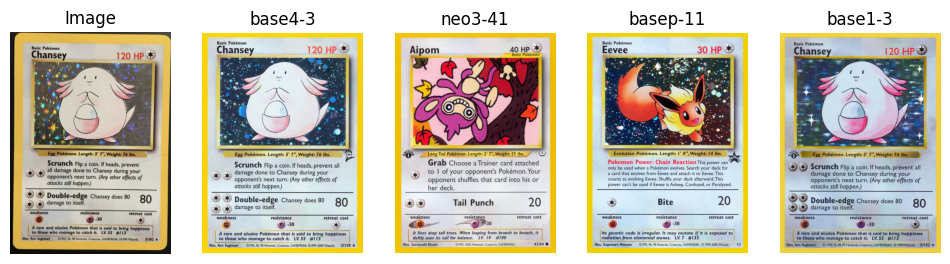

took 2.3495049476623535 seconds
charizard:
('base4-4', 66)
('lc-3', 72)
('base1-4', 77)
('lc-54', 78)


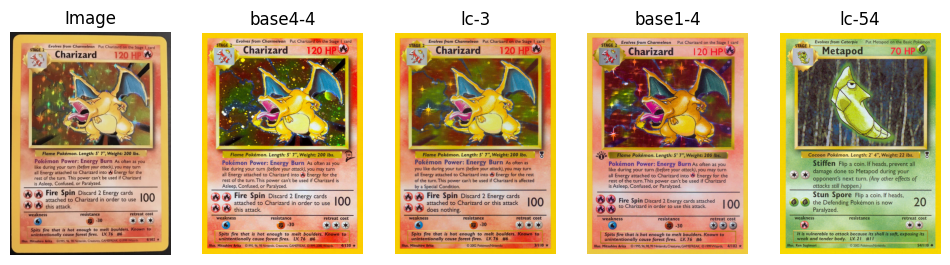

took 3.90254807472229 seconds
breeder:
('base1-76', 65)
('lc-102', 67)
('base4-105', 77)
('gym2-109', 86)


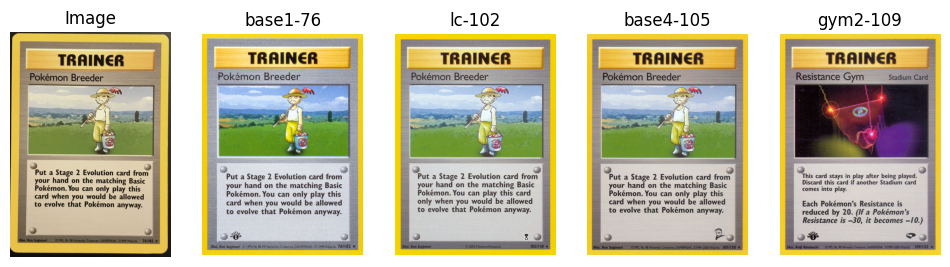

took 3.845715284347534 seconds
mewtwo:
('base4-10', 56)
('neo4-3', 64)
('base1-10', 65)
('base2-50', 65)


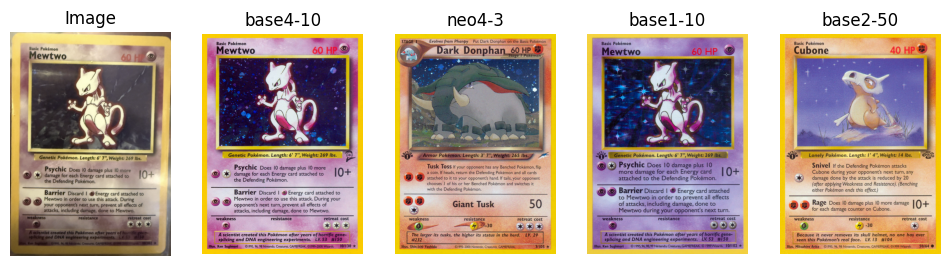

took 2.4758551120758057 seconds
on average, took 3.143405854701996


In [83]:
total_time = 0
pokemons = ['chansey', 'charizard', 'breeder', 'mewtwo']
for pokemon in pokemons:
    print(f'{pokemon}:')
    time_taken = test_model_i2i(pokemon)
    total_time += time_taken
    print(f'took {time_taken} seconds')

print(f'on average, took {total_time / len(pokemons)}')